In [1]:
# Torch Imports
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader

# PLiNIO imports
from plinio.methods import PIT, SuperNet
from plinio.methods.mps import MPS, MPSType, get_default_qinfo
from plinio.methods.supernet import SuperNetModule
from plinio.cost import params, ops, params_bit, ops_bit
from plinio.regularizers import DUCCIO

# Stats imports
# import pandas as pd
import matplotlib.pyplot as plt

# Utils imports
import utils
from copy import deepcopy as dc

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Dataset and DataLoader

In [3]:
# Transforms: we need to upscale our images
transforms = T.Compose([T.Resize([224,224]), T.ToTensor()])

In [4]:
# 1.Training set
train_dataset = torchvision.datasets.MNIST(
    root='./Datasets/MNIST',
    train=True,
    download=True,
    transform=transforms,
    target_transform=None
)

# 2. Test set
test_dataset = torchvision.datasets.MNIST(
    root='./Datasets/MNIST',
    train=False,
    download=True,
    transform=transforms,
    target_transform=None
)

In [5]:
# Information about the dataset
random_sample = train_dataset[torch.randint(0, len(train_dataset), size=[1]).item()][0]
class_names = train_dataset.classes

print(f'#Training samples: {len(train_dataset)}')
print(f'#Test samples: {len(test_dataset)}')

print(f'\n#Classes: {len(class_names)}')
print(f'List of classes: {class_names}')

print(f'\nData shape: {random_sample.shape}')

#Training samples: 60000
#Test samples: 10000

#Classes: 10
List of classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Data shape: torch.Size([1, 224, 224])


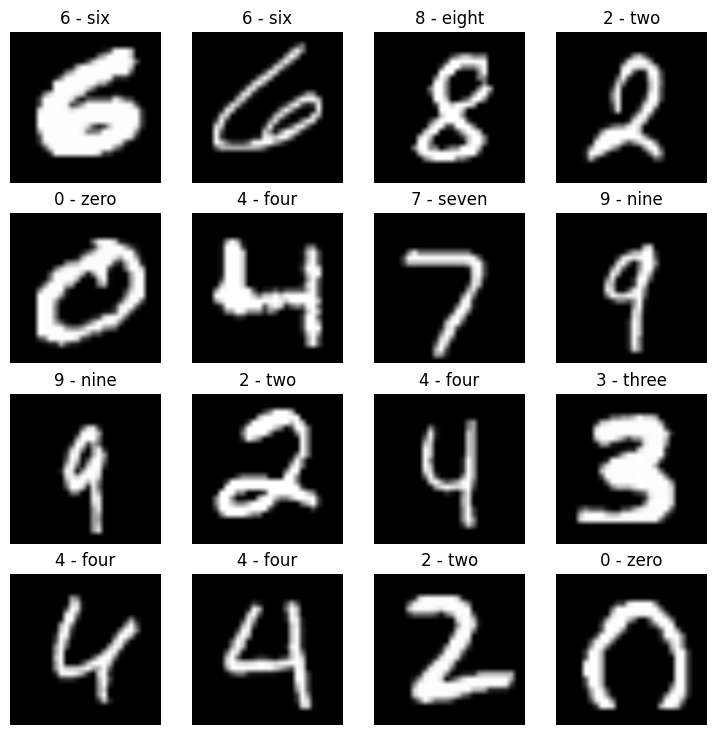

In [5]:
torch.manual_seed(42)
ROWS, COLS = 4, 4

# Data visualization
fig = plt.figure(figsize=[9, 9])
for i in range(1, ROWS*COLS+1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(ROWS, COLS, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [6]:
BATCH_SIZE = 16

# 1. Training data loader
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=0
)

# 2. Testing data loader
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0
)

print(f'Created {len(train_dataloader)} training batches of {BATCH_SIZE} samples.')
print(f'Created {len(test_dataloader)} testing batches of {BATCH_SIZE} samples.')

Created 3750 training batches of 16 samples.
Created 625 testing batches of 16 samples.


# 2. VGG16 Model

In [9]:
torch.manual_seed(42)

# Load the PyTorch model
model = torchvision.models.vgg16()

# Model structure
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# We are working with gray scale images
num_channels = train_dataset[0][0].shape[0]
print(f'#Channels of our images: {num_channels}')

#Channels of our images: 1


In [11]:
torch.manual_seed(42)

# We need to change the 1st convolutional layer
old_layer = model.features[0]
new_layer = nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1)
model.features[0] = new_layer

print(f'Old layer: {old_layer}')
print(f'New layer: {new_layer}')

Old layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
New layer: Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [12]:
torch.manual_seed(42)

# We need to change the last fully connected layer to output 10 values
old_fc = model.classifier[-1]
new_fc = nn.Linear(in_features=4096, out_features=len(class_names))
model.classifier[-1] = new_fc

print(f'Old layer: {old_fc}')
print(f'New layer: {new_fc}')

Old layer: Linear(in_features=4096, out_features=1000, bias=True)
New layer: Linear(in_features=4096, out_features=10, bias=True)


In [13]:
# New model
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# Save the model starting point for opitmization
torch.save(model, './Models_checkpoints/VGG16_MNIST_Init.pth')

# 3. Traning loops

## 3.1 Model without optimization

In [16]:
# Setup optimizer and loss function
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the standard model
NoOpt_results = utils.train_model(
    model=model,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer
)

print(f"Total training time (on {NoOpt_results['device']}): {NoOpt_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {NoOpt_results['device']}): {(NoOpt_results['total_time']//3)} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 2.28934 | Avg Accuracy: 15.59%
Computed 999/3750 batches - Avg Loss: 1.72211 | Avg Accuracy: 39.03%
Computed 1499/3750 batches - Avg Loss: 1.26777 | Avg Accuracy: 55.59%
Computed 1999/3750 batches - Avg Loss: 1.01717 | Avg Accuracy: 64.66%
Computed 2499/3750 batches - Avg Loss: 0.85605 | Avg Accuracy: 70.41%
Computed 2999/3750 batches - Avg Loss: 0.74336 | Avg Accuracy: 74.38%
Computed 3499/3750 batches - Avg Loss: 0.65743 | Avg Accuracy: 77.37%

End of EPOCH 0 - Avg Loss: 0.62441 | Avg Accuracy: 78.55%
Training time: 656.542 seconds.
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.13478 | Avg Accuracy: 95.83%
Computed 999/3750 batches - Avg Loss: 0.12712 | Avg Accuracy: 96.00%
Computed 1499/3750 batches - Avg Loss: 0.12301 | Avg Accuracy: 96.15%
Computed 1999/3750 batches - Avg Loss: 0.11582 | Avg Accuracy: 96.38%
Computed 2499/3750 batches - Avg Loss: 0.11330 | Avg Accuracy: 96.46%
Computed 2999/3750 batches - Avg Loss: 0.10982 | Avg Accuracy: 96.58%
Computed 3499/3750 batches - Avg Loss: 0.10830 | Avg Accuracy: 96.63%

End of EPOCH 1 - Avg Loss: 0.10745 | Avg Accuracy: 96.62%
Training time: 656.087 seconds.
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.08476 | Avg Accuracy: 97.73%
Computed 999/3750 batches - Avg Loss: 0.08632 | Avg Accuracy: 97.54%
Computed 1499/3750 batches - Avg Loss: 0.08346 | Avg Accuracy: 97.56%
Computed 1999/3750 batches - Avg Loss: 0.08022 | Avg Accuracy: 97.60%
Computed 2499/3750 batches - Avg Loss: 0.07974 | Avg Accuracy: 97.60%
Computed 2999/3750 batches - Avg Loss: 0.07756 | Avg Accuracy: 97.66%
Computed 3499/3750 batches - Avg Loss: 0.07580 | Avg Accuracy: 97.70%

End of EPOCH 2 - Avg Loss: 0.07568 | Avg Accuracy: 97.69%
Training time: 656.675 seconds.
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.06517 | Avg Accuracy: 98.22%
Computed 999/3750 batches - Avg Loss: 0.06581 | Avg Accuracy: 98.10%
Computed 1499/3750 batches - Avg Loss: 0.06316 | Avg Accuracy: 98.11%
Computed 1999/3750 batches - Avg Loss: 0.06203 | Avg Accuracy: 98.09%
Computed 2499/3750 batches - Avg Loss: 0.06244 | Avg Accuracy: 98.06%
Computed 2999/3750 batches - Avg Loss: 0.06037 | Avg Accuracy: 98.12%
Computed 3499/3750 batches - Avg Loss: 0.05951 | Avg Accuracy: 98.16%

End of EPOCH 3 - Avg Loss: 0.05985 | Avg Accuracy: 98.13%
Training time: 657.092 seconds.
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.05191 | Avg Accuracy: 98.66%
Computed 999/3750 batches - Avg Loss: 0.04857 | Avg Accuracy: 98.63%
Computed 1499/3750 batches - Avg Loss: 0.04924 | Avg Accuracy: 98.57%
Computed 1999/3750 batches - Avg Loss: 0.04956 | Avg Accuracy: 98.53%
Computed 2499/3750 batches - Avg Loss: 0.04973 | Avg Accuracy: 98.54%
Computed 2999/3750 batches - Avg Loss: 0.04881 | Avg Accuracy: 98.54%
Computed 3499/3750 batches - Avg Loss: 0.04846 | Avg Accuracy: 98.54%

End of EPOCH 4 - Avg Loss: 0.04826 | Avg Accuracy: 98.52%
Training time: 656.839 seconds.
********************

Total training time (on cuda): 3283.236 seconds.
Avg training time (on cuda): 1094.0 seconds.


In [18]:
# Save the trained model weights as checkpoint
torch.save(model, './Models_checkpoints/VGG16_MNIST_NoOpt.pth')

## 3.2 Models with optimization

In the following sections, the standard training loop will be modified with **PLiNIO** cost specifications, depending on the applied optimization method.

### 3.2.1 Pruning In Time (**PIT**)

In [19]:
# Load VGG16 initialization
PIT_init = torch.load('./Models_checkpoints/VGG16_MNIST_Init.pth')

# Create PIT PLiNIO model object with parameters cost
PIT_model = PIT(model=PIT_init, input_shape=torch.Size([1,224,244]), cost={'size': params})
initial_size = PIT_model.get_cost('size').item()

print(f'#Parameters before PIT optimization: {int(initial_size)}')

#Parameters before PIT optimization: 134300368


In [20]:
# Setup loss_fn and regularizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=PIT_model.parameters(), lr=0.001)

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with PIT optimization
PIT_results = utils.train_model(
    model=PIT_model,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    optim_method='PIT',
    cost_strength={'size': 1e-6}
)

print(f"Total training time (on {PIT_results['device']}): {PIT_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {PIT_results['device']}): {(PIT_results['total_time']//3)} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 130.63078 | Avg Accuracy: 15.57%
Computed 999/3750 batches - Avg Loss: 123.89909 | Avg Accuracy: 38.97%
Computed 1499/3750 batches - Avg Loss: 117.54298 | Avg Accuracy: 55.52%
Computed 1999/3750 batches - Avg Loss: 111.57451 | Avg Accuracy: 64.59%
Computed 2499/3750 batches - Avg Loss: 105.85162 | Avg Accuracy: 70.34%
Computed 2999/3750 batches - Avg Loss: 100.41116 | Avg Accuracy: 71.65%
Computed 3499/3750 batches - Avg Loss: 95.06672 | Avg Accuracy: 74.10%

End of EPOCH 0 - Avg Loss: 92.41725 | Avg Accuracy: 75.15%
Training time: 709.280 seconds.

#Parameters after EPOCH 0: 52982484
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 48.58401 | Avg Accuracy: 92.25%
Computed 999/3750 batches - Avg Loss: 43.80476 | Avg Accuracy: 92.97%
Computed 1499/3750 batches - Avg Loss: 39.17672 | Avg Accuracy: 93.57%
Computed 1999/3750 batches - Avg Loss: 36.07949 | Avg Accuracy: 94.04%
Computed 2499/3750 batches - Avg Loss: 34.19025 | Avg Accuracy: 94.36%
Computed 2999/3750 batches - Avg Loss: 32.90173 | Avg Accuracy: 94.61%
Computed 3499/3750 batches - Avg Loss: 31.96011 | Avg Accuracy: 94.74%

End of EPOCH 1 - Avg Loss: 31.56635 | Avg Accuracy: 94.79%
Training time: 720.156 seconds.

#Parameters after EPOCH 1: 26008272
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 26.10406 | Avg Accuracy: 96.58%
Computed 999/3750 batches - Avg Loss: 26.00542 | Avg Accuracy: 96.58%
Computed 1499/3750 batches - Avg Loss: 25.92269 | Avg Accuracy: 96.60%
Computed 1999/3750 batches - Avg Loss: 25.84581 | Avg Accuracy: 96.61%
Computed 2499/3750 batches - Avg Loss: 25.76935 | Avg Accuracy: 96.70%
Computed 2999/3750 batches - Avg Loss: 25.69420 | Avg Accuracy: 96.76%
Computed 3499/3750 batches - Avg Loss: 25.62127 | Avg Accuracy: 96.76%

End of EPOCH 2 - Avg Loss: 25.57796 | Avg Accuracy: 96.77%
Training time: 721.905 seconds.

#Parameters after EPOCH 2: 24945292
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 25.01948 | Avg Accuracy: 97.32%
Computed 999/3750 batches - Avg Loss: 24.92312 | Avg Accuracy: 97.22%
Computed 1499/3750 batches - Avg Loss: 24.84325 | Avg Accuracy: 97.30%
Computed 1999/3750 batches - Avg Loss: 24.76944 | Avg Accuracy: 97.31%
Computed 2499/3750 batches - Avg Loss: 24.69961 | Avg Accuracy: 97.27%
Computed 2999/3750 batches - Avg Loss: 24.62771 | Avg Accuracy: 97.37%
Computed 3499/3750 batches - Avg Loss: 24.55772 | Avg Accuracy: 97.43%

End of EPOCH 3 - Avg Loss: 24.51660 | Avg Accuracy: 97.42%
Training time: 721.751 seconds.

#Parameters after EPOCH 3: 23930356
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 23.98452 | Avg Accuracy: 97.75%
Computed 999/3750 batches - Avg Loss: 23.88949 | Avg Accuracy: 97.89%
Computed 1499/3750 batches - Avg Loss: 23.81742 | Avg Accuracy: 97.79%
Computed 1999/3750 batches - Avg Loss: 23.74986 | Avg Accuracy: 97.75%
Computed 2499/3750 batches - Avg Loss: 23.68278 | Avg Accuracy: 97.76%
Computed 2999/3750 batches - Avg Loss: 23.61575 | Avg Accuracy: 97.80%
Computed 3499/3750 batches - Avg Loss: 23.54963 | Avg Accuracy: 97.83%

End of EPOCH 4 - Avg Loss: 23.51082 | Avg Accuracy: 97.79%
Training time: 722.402 seconds.

#Parameters after EPOCH 4: 22960812
********************

Total training time (on cuda): 3595.494 seconds.
Avg training time (on cuda): 1198.0 seconds.


In [22]:
# Check the results of optimization
optim_size = PIT_model.get_cost('size')
print(f'#Parameters went from {int(initial_size)} to {int(optim_size)} -> {((1 - (optim_size/initial_size))*100):.2f}% fewer parameters.')

#Parameters went from 134300368 to 22960812 ->s 82.90% fewer parameters.


In [23]:
# Convert the model to PyTorch vanilla and save it
PIT_exported = PIT_model.export()
torch.save(PIT_exported, './Models_checkpoints/VGG16_MNIST_PIT.pth')

### 3.2.2 Cost-aware Pruning In Time (PIT with **DUCCIO** regularizer)
*DUCCIO* regularizer is a feature of PLiNIO that allows to both eaily deal with multi-constraint optimization and treat cost metrics as constraints rather than just secondary objectives. The latter trait allows the regularizer to penalize the loss, whenever those constraints are exceeded, forcing the optimization to search only in a restricted space of the possible networks.

In the following example of application, we focus as before on the number of parameters in addition to the number of **FLOPS** (_floating point operations_), trying to look for a model, which uses <u>only 10%</u> both of the original parameters and the original FLOPS.

In [13]:
# Load VGG16 initialization
PIT_duccio_init = torch.load('./Models_checkpoints/VGG16_MNIST_Init.pth')

# Create PIT PLiNIO model object with parameters and FLOPS cost
PIT_duccio = PIT(model=PIT_duccio_init, input_shape=random_sample.shape, cost={'#Parameters': params, '#FLOPS': ops})
initial_params = PIT_duccio.get_cost('#Parameters').item()
initial_flops = PIT_duccio.get_cost('#FLOPS').item()

# Define the constraint for the regularizer - 10% of the original parameters and FLOPS
constraint_params = torch.tensor(initial_params*0.1, device=device)
constraint_flops = torch.tensor(initial_flops*0.1, device=device)
params_strength = torch.tensor(1e-6, device=device)
flops_strength = torch.tensor(1e-9, device=device)

print(f'#Parameters before PIT optimization: {int(initial_params)}')
print(f'#FLOPS before PIT optimization: {int(initial_flops)}')

print(f'\nConstraint for DUCCIO regularizer (parameters): {int(constraint_params.item())} parameters.')
print(f'Constraint for DUCCIO regularizer (FLOPS): {int(constraint_flops.item())} parameters.')

# Create the regularizer
regularizer = DUCCIO({'#Parameters': constraint_params, '#FLOPS': constraint_flops}, final_strengths=(params_strength, flops_strength))

#Parameters before PIT optimization: 134300368
#FLOPS before PIT optimization: 15421962240

Constraint for DUCCIO regularizer (parameters): 13430037 parameters.
Constraint for DUCCIO regularizer (FLOPS): 1542196224 parameters.


In [14]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=PIT_duccio.parameters(), lr=0.001)

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with PIT optimization and DUCCIO regularizer
PIT_duccio_results = utils.train_model_duccio(
    model=PIT_duccio,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    cost_names=['#Parameters', '#FLOPS'],
    regularizer=regularizer
)

print(f"Total training time (on {PIT_duccio_results['device']}): {PIT_duccio_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {PIT_duccio_results['device']}): {(PIT_duccio_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 3.63884 | Avg Accuracy: 15.51%
Computed 999/3750 batches - Avg Loss: 3.06974 | Avg Accuracy: 38.99%
Computed 1499/3750 batches - Avg Loss: 2.61461 | Avg Accuracy: 55.58%
Computed 1999/3750 batches - Avg Loss: 2.36375 | Avg Accuracy: 64.58%
Computed 2499/3750 batches - Avg Loss: 2.20216 | Avg Accuracy: 70.32%
Computed 2999/3750 batches - Avg Loss: 2.08899 | Avg Accuracy: 74.31%
Computed 3499/3750 batches - Avg Loss: 2.00244 | Avg Accuracy: 77.35%

End of EPOCH 0 - Avg Loss: 1.96858 | Avg Accuracy: 78.53%
Training time: 820.323 seconds.

#Parameters after epoch EPOCH 0: 133365688
#FLOPS after epoch EPOCH 0: 15409297408
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 53.49565 | Avg Accuracy: 96.00%
Computed 999/3750 batches - Avg Loss: 52.37258 | Avg Accuracy: 96.13%
Computed 1499/3750 batches - Avg Loss: 51.30109 | Avg Accuracy: 96.27%
Computed 1999/3750 batches - Avg Loss: 50.25135 | Avg Accuracy: 96.48%
Computed 2499/3750 batches - Avg Loss: 49.22105 | Avg Accuracy: 96.54%
Computed 2999/3750 batches - Avg Loss: 48.20426 | Avg Accuracy: 96.63%
Computed 3499/3750 batches - Avg Loss: 47.20156 | Avg Accuracy: 96.67%

End of EPOCH 1 - Avg Loss: 46.69179 | Avg Accuracy: 96.68%
Training time: 819.610 seconds.

#Parameters after epoch EPOCH 1: 97137992
#FLOPS after epoch EPOCH 1: 14327896064
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 73.97227 | Avg Accuracy: 97.82%
Computed 999/3750 batches - Avg Loss: 70.31462 | Avg Accuracy: 97.56%
Computed 1499/3750 batches - Avg Loss: 66.89851 | Avg Accuracy: 94.00%
Computed 1999/3750 batches - Avg Loss: 63.49992 | Avg Accuracy: 92.89%
Computed 2499/3750 batches - Avg Loss: 60.13520 | Avg Accuracy: 92.60%
Computed 2999/3750 batches - Avg Loss: 56.81189 | Avg Accuracy: 92.59%
Computed 3499/3750 batches - Avg Loss: 53.52438 | Avg Accuracy: 92.73%

End of EPOCH 2 - Avg Loss: 51.88052 | Avg Accuracy: 92.79%
Training time: 845.761 seconds.

#Parameters after epoch EPOCH 2: 36632408
#FLOPS after epoch EPOCH 2: 12409352192
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 29.46466 | Avg Accuracy: 95.47%
Computed 999/3750 batches - Avg Loss: 26.39028 | Avg Accuracy: 95.52%
Computed 1499/3750 batches - Avg Loss: 25.16171 | Avg Accuracy: 95.62%
Computed 1999/3750 batches - Avg Loss: 24.42935 | Avg Accuracy: 95.71%
Computed 2499/3750 batches - Avg Loss: 23.89997 | Avg Accuracy: 95.76%
Computed 2999/3750 batches - Avg Loss: 23.46895 | Avg Accuracy: 95.97%
Computed 3499/3750 batches - Avg Loss: 23.10197 | Avg Accuracy: 96.07%

End of EPOCH 3 - Avg Loss: 22.92851 | Avg Accuracy: 96.12%
Training time: 843.084 seconds.

#Parameters after epoch EPOCH 3: 24731102
#FLOPS after epoch EPOCH 3: 10628096000
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 20.32356 | Avg Accuracy: 96.93%
Computed 999/3750 batches - Avg Loss: 20.09767 | Avg Accuracy: 97.13%
Computed 1499/3750 batches - Avg Loss: 19.89418 | Avg Accuracy: 97.03%
Computed 1999/3750 batches - Avg Loss: 19.69518 | Avg Accuracy: 97.12%
Computed 2499/3750 batches - Avg Loss: 19.49798 | Avg Accuracy: 97.20%
Computed 2999/3750 batches - Avg Loss: 19.30305 | Avg Accuracy: 97.24%
Computed 3499/3750 batches - Avg Loss: 19.11138 | Avg Accuracy: 97.27%

End of EPOCH 4 - Avg Loss: 19.01157 | Avg Accuracy: 97.25%
Training time: 843.873 seconds.

#Parameters after epoch EPOCH 4: 23330316
#FLOPS after epoch EPOCH 4: 9158947840
********************

Total training time (on cuda): 4172.653 seconds.
Avg training time (on cuda): 1390.884 seconds.


In [16]:
# Check the results of optimization
optim_params = PIT_duccio.get_cost('#Parameters').item()
optim_flops = PIT_duccio.get_cost('#FLOPS').item()

print(f'#Parameters went from {int(initial_params)} to {int(optim_params)} -> {((1 - (optim_params/initial_params))*100):.2f}% fewer parameters.')
print(f'#FLOPS went from {int(initial_flops)} to {int(optim_flops)} -> {((1 - (optim_flops/initial_flops))*100):.2f}% fewer FLOPS.')

#Parameters went from 134300368 to 23330316 -> 82.63% fewer parameters.
#FLOPS went from 15421962240 to 9158947840 -> 40.61% fewer FLOPS.


In [17]:
# Convert the model to PyTorch vanilla and save it
PIT_duccio_exported = PIT_duccio.export()
torch.save(PIT_duccio_exported, './Models_checkpoints/VGG16_MNIST_PIT_duccio.pth')

### 3.2.3 Mixed-Precision Search (**MPS**)

In [7]:
# Load VGG16 initialization
MPS_init = torch.load('./Models_checkpoints/VGG16_MNIST_Init.pth')

In [8]:
# Create the baseline model to retrieve the full model costs
model_baseline =  MPS(model=MPS_init,
                input_shape=random_sample.shape,
                qinfo=get_default_qinfo(
                    w_precision=(32,), # torch uses 32-bit floating point
                    a_precision=(32,)  # torch uses 32-bit floating point
                ),
                w_search_type=MPSType.PER_LAYER,
                cost={'size': params_bit, 'macs': ops_bit})

# Bits required for storing the model's weights
initial_storage = model_baseline.get_cost('size').item()
# BitOPS performed by the model
initial_bitops = model_baseline.get_cost('macs').item()

print(f"Storage required for weights: {(initial_storage/(8*1024**2)):.2f} MB - {int(initial_storage)} bits")
print(f"#BitOPS: {int(initial_bitops)}")

Storage required for weights: 512.27 MB - 4297213952 bits
#BitOPS: 15778208284672


In [9]:
# Create the PLiNIO model object with costs to optimize
MPS_model = MPS(model=MPS_init,
                input_shape=random_sample.shape,
                qinfo=get_default_qinfo(
                    w_precision=(8,16), # bit-widths to consider for weights
                    a_precision=(8,16)  # bit-widths to consider for activations
                ),
                w_search_type=MPSType.PER_LAYER,
                cost={'size': params_bit})

starting_storage = MPS_model.get_cost('size').item()

print(f"Starting storage required for weights: {(starting_storage/(8*1024**2)):.2f} MB - {int(starting_storage)} bits")

Starting storage required for weights: 207.78 MB - 1743013888 bits


In [10]:
# Initial precisions assigned to the layers 
MPS_model.summary()

{'x_input_quantizer': {'out_precision': 16, 'type': 'MPSIdentity'},
 'features.0': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.2': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.5': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.7': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.10': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.12': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.14': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.17': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.19': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSC

In [11]:
# Setup loss_fn and regularizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=MPS_model.parameters(), lr=0.001)

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with MPS optimization
MPS_results = utils.train_model(
    model=MPS_model,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    optim_method='MPS',
    cost_strength={'size': 1e-8}
)

print(f"Total training time (on {MPS_results['device']}): {MPS_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {MPS_results['device']}): {(MPS_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 17.79769 | Avg Accuracy: 14.89%
Computed 999/3750 batches - Avg Loss: 16.13983 | Avg Accuracy: 37.90%
Computed 1499/3750 batches - Avg Loss: 15.08787 | Avg Accuracy: 54.69%
Computed 1999/3750 batches - Avg Loss: 14.45590 | Avg Accuracy: 63.95%
Computed 2499/3750 batches - Avg Loss: 14.02703 | Avg Accuracy: 69.79%
Computed 2999/3750 batches - Avg Loss: 13.71348 | Avg Accuracy: 73.84%
Computed 3499/3750 batches - Avg Loss: 13.46859 | Avg Accuracy: 76.96%

End of EPOCH 0 - Avg Loss: 13.36428 | Avg Accuracy: 78.15%
Training time: 3545.885 seconds.

Storage required for weights: 140.34 MB - 1177226624 bits
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 11.89836 | Avg Accuracy: 95.89%
Computed 999/3750 batches - Avg Loss: 11.85263 | Avg Accuracy: 96.03%
Computed 1499/3750 batches - Avg Loss: 11.81936 | Avg Accuracy: 96.14%
Computed 1999/3750 batches - Avg Loss: 11.78758 | Avg Accuracy: 96.36%
Computed 2499/3750 batches - Avg Loss: 11.76223 | Avg Accuracy: 96.49%
Computed 2999/3750 batches - Avg Loss: 11.73859 | Avg Accuracy: 96.59%
Computed 3499/3750 batches - Avg Loss: 11.71889 | Avg Accuracy: 96.61%

End of EPOCH 1 - Avg Loss: 11.70579 | Avg Accuracy: 96.64%
Training time: 3582.181 seconds.

Storage required for weights: 136.76 MB - 1147193984 bits
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 11.57029 | Avg Accuracy: 97.53%
Computed 999/3750 batches - Avg Loss: 11.54902 | Avg Accuracy: 97.37%
Computed 1499/3750 batches - Avg Loss: 11.53194 | Avg Accuracy: 97.40%
Computed 1999/3750 batches - Avg Loss: 11.51545 | Avg Accuracy: 97.49%
Computed 2499/3750 batches - Avg Loss: 11.50312 | Avg Accuracy: 97.52%
Computed 2999/3750 batches - Avg Loss: 11.49005 | Avg Accuracy: 97.59%
Computed 3499/3750 batches - Avg Loss: 11.47861 | Avg Accuracy: 97.62%

End of EPOCH 2 - Avg Loss: 11.47047 | Avg Accuracy: 97.61%
Training time: 3579.715 seconds.

Storage required for weights: 135.00 MB - 1132489216 bits
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 11.41152 | Avg Accuracy: 98.01%
Computed 999/3750 batches - Avg Loss: 11.39001 | Avg Accuracy: 97.95%
Computed 1499/3750 batches - Avg Loss: 11.37528 | Avg Accuracy: 98.02%
Computed 1999/3750 batches - Avg Loss: 11.36482 | Avg Accuracy: 98.02%
Computed 2499/3750 batches - Avg Loss: 11.35665 | Avg Accuracy: 98.03%
Computed 2999/3750 batches - Avg Loss: 11.34670 | Avg Accuracy: 98.12%
Computed 3499/3750 batches - Avg Loss: 11.33873 | Avg Accuracy: 98.15%

End of EPOCH 3 - Avg Loss: 11.33210 | Avg Accuracy: 98.12%
Training time: 3501.144 seconds.

Storage required for weights: 133.80 MB - 1122355968 bits
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 11.29406 | Avg Accuracy: 98.48%
Computed 999/3750 batches - Avg Loss: 11.27392 | Avg Accuracy: 98.44%
Computed 1499/3750 batches - Avg Loss: 11.26447 | Avg Accuracy: 98.43%
Computed 1999/3750 batches - Avg Loss: 11.25716 | Avg Accuracy: 98.47%
Computed 2499/3750 batches - Avg Loss: 11.25168 | Avg Accuracy: 98.47%
Computed 2999/3750 batches - Avg Loss: 11.24459 | Avg Accuracy: 98.52%
Computed 3499/3750 batches - Avg Loss: 11.23853 | Avg Accuracy: 98.54%

End of EPOCH 4 - Avg Loss: 11.23293 | Avg Accuracy: 98.51%
Training time: 3538.836 seconds.

Storage required for weights: 132.90 MB - 1114853504 bits
********************

Total training time (on cuda): 17747.761 seconds.
Avg training time (on cuda): 5915.920 seconds.


In [13]:
optimized_storage = MPS_model.get_cost('size').item()

print(f'Storage required for weights after MPS: {(optimized_storage/(8*1024**2)):.2f} MB -> {((1 - (optimized_storage/initial_storage))*100):.2f}% less space required.')

Storage required for weights after MPS: 132.90 MB -> 74.06% less space required.


In [14]:
# Final precisions assigned to the layers
MPS_model.summary() 

{'x_input_quantizer': {'out_precision': 16, 'type': 'MPSIdentity'},
 'features.0': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.2': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.5': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.7': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.10': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.12': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.14': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.17': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 8,
  'type': 'MPSConv2d'},
 'features.19': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 8,
  'type': 'MPSCon

In [17]:
# Convert the model to PyTorch vanilla
MPS_exported = MPS_model.export()

# Setup loss_fn and regularizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=MPS_exported.parameters(), lr=0.001)

# A couple of more epochs for fine-tuning
_ = utils.train_model(
    model=MPS_exported,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=2    
)

# Save the model
torch.save(MPS_exported, './Models_checkpoints/VGG16_MNIST_MPS.pth')

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.04700 | Avg Accuracy: 98.75%
Computed 999/3750 batches - Avg Loss: 0.04551 | Avg Accuracy: 98.74%
Computed 1499/3750 batches - Avg Loss: 0.04691 | Avg Accuracy: 98.65%
Computed 1999/3750 batches - Avg Loss: 0.04500 | Avg Accuracy: 98.68%
Computed 2499/3750 batches - Avg Loss: 0.04523 | Avg Accuracy: 98.66%
Computed 2999/3750 batches - Avg Loss: 0.04548 | Avg Accuracy: 98.67%
Computed 3499/3750 batches - Avg Loss: 0.04471 | Avg Accuracy: 98.67%

End of EPOCH 0 - Avg Loss: 0.04413 | Avg Accuracy: 98.65%
Training time: 1234.940 seconds.
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.04112 | Avg Accuracy: 98.99%
Computed 999/3750 batches - Avg Loss: 0.04007 | Avg Accuracy: 98.86%
Computed 1499/3750 batches - Avg Loss: 0.03991 | Avg Accuracy: 98.80%
Computed 1999/3750 batches - Avg Loss: 0.03864 | Avg Accuracy: 98.84%
Computed 2499/3750 batches - Avg Loss: 0.03905 | Avg Accuracy: 98.82%
Computed 2999/3750 batches - Avg Loss: 0.03938 | Avg Accuracy: 98.80%
Computed 3499/3750 batches - Avg Loss: 0.03865 | Avg Accuracy: 98.82%

End of EPOCH 1 - Avg Loss: 0.03917 | Avg Accuracy: 98.78%
Training time: 1235.607 seconds.
********************



In [18]:
MPS_exported

VGG(
  (x_input_quantizer): QuantIdentity(
    (out_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
    tensor([1.0000], requires_grad=True), scale_factor=1.5259027350111865e-05)
  )
  (features): Module(
    (0): QuantConv2d(
      1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (in_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
      tensor([1.0000], requires_grad=True), scale_factor=1.5259027350111865e-05)
      (out_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
      tensor([6.], requires_grad=True), scale_factor=9.155413135886192e-05)
      (w_quantizer): MinMaxWeight(precision=16, scale_factor=tensor([9.6613e-06, 9.1456e-06, 8.0300e-06, 1.0048e-05, 9.5174e-06, 1.0070e-05,
              8.0374e-06, 9.1361e-06, 1.0091e-05, 7.8773e-06, 9.3102e-06, 9.8430e-06,
              1.0170e-05, 8.9516e-06, 8.7264e-06, 1.0114e-05, 9.3645e-06, 9.1059e-06,
              8.9647e-06, 9.5770e-06, 5.4801e-06, 8.7422e-06, 9.2163e-06

### 3.2.4 SuperNet

In [18]:
SuperNet_init = torch.load('./Models_checkpoints/VGG16_MNIST_Init.pth')

# Initial structure
SuperNet_init

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In order to apply SuperNet optimization, we need to manually define alternatives for either single layers or enitre modules if the original structure. The alternatives you see down below have been tested, so that all of them do not compromise the training phase, meaning that the model should still learn.

VGG structure is mainly composed of two kinds of layers: **Convolutional** and **Linear**. Therefore the alternatives being considered are either special forms of these layers or the same layers with less parameters:
* for the _convolutional_ layers, since the `SuperNetModule` requires alternatives with the same output shape, we have selected specific convolutional layers of the VGG feature extractor, by considering either a **depth-wise** or a **point-wise** version of those layers;
* for the _linear_ layers, we have considered variations of the VGG classifier structure, by considering either the same number of layers with less parameters (hidden units) or a lower number of layers with less number of parameters (hidden units) 

In [19]:
# Original features structure
original_features = SuperNet_init.features

# 1st alternative - depth-wise convolution on layers increasing the number of channels
alt_1 = dc(original_features)
alt_1[5] = nn.Conv2d(original_features[5].in_channels, original_features[5].out_channels, original_features[5].kernel_size, stride=1, padding=original_features[5].padding, groups=original_features[5].in_channels)
alt_1[10] = nn.Conv2d(original_features[10].in_channels, original_features[10].out_channels, original_features[10].kernel_size, stride=1, padding=original_features[10].padding, groups=original_features[10].in_channels)
alt_1[17] = nn.Conv2d(original_features[17].in_channels, original_features[17].out_channels, original_features[17].kernel_size, stride=1, padding=original_features[17].padding, groups=original_features[17].in_channels)

# 2nd alternative - point-wise convolution on layers increasing the number of channels
alt_2 = dc(original_features)
alt_2[5] = nn.Conv2d(original_features[5].in_channels, original_features[5].out_channels, kernel_size=1 , stride=1)
alt_2[10] = nn.Conv2d(original_features[10].in_channels, original_features[10].out_channels,  kernel_size=1 , stride=1)
alt_2[17] = nn.Conv2d(original_features[17].in_channels, original_features[17].out_channels,  kernel_size=1 , stride=1)

# 3rd alternative - depth-wise convolution on the last 2 convolutional layers
alt_3 = dc(original_features)
alt_3[26] = nn.Conv2d(original_features[26].in_channels, original_features[26].out_channels, original_features[26].kernel_size, stride=1, padding=original_features[26].padding, groups=original_features[26].in_channels)
alt_3[28] = nn.Conv2d(original_features[28].in_channels, original_features[28].out_channels, original_features[28].kernel_size, stride=1, padding=original_features[28].padding, groups=original_features[28].in_channels)

In [20]:
# Original model's classifier structure
original_classifier = SuperNet_init.classifier

# 1st alternative
classifier_1 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=10, bias=True)
)

# 2nd alternative
classifier_2 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=10, bias=True)
)

# 3rd alternative
classifier_3 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=10, bias=True)
)

In [21]:
# Modify the features structure for SuperNet optimization
SuperNet_init.features = SuperNetModule([
    original_features,
    alt_1,
    alt_2,
    alt_3
])

# Modify the classifer structure for SuperNet optimization
SuperNet_init.classifier = SuperNetModule([
    original_classifier,
    classifier_1,
    classifier_2,
    classifier_3
])

# New structure
SuperNet_init

VGG(
  (features): SuperNetModule(
    (sn_branches): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(

In [17]:
# Create PIT PLiNIO model object with parameters cost
SuperNet_model = SuperNet(SuperNet_init, input_shape=random_sample.shape, cost={'size': params})

initial_params = SuperNet_model.get_cost('size').item()
print(f"Parameters cost befor SuperNet optimization: {int(SuperNet_model.get_cost('size').item())}")

Parameters cost befor SuperNet optimization: 76264656


In [18]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(SuperNet_model.parameters(), lr=0.001)

In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with SuperNet optimization
SuperNet_results = utils.train_model(
    model=SuperNet_model,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    optim_method='SuperNet',
    cost_strength={'size': 1e-7}
)

print(f"Total training time (on {SuperNet_results['device']}): {SuperNet_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {SuperNet_results['device']}): {(SuperNet_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 9.32842 | Avg Accuracy: 11.03%
Computed 999/3750 batches - Avg Loss: 8.85316 | Avg Accuracy: 11.64%
Computed 1499/3750 batches - Avg Loss: 8.46692 | Avg Accuracy: 12.31%
Computed 1999/3750 batches - Avg Loss: 8.15258 | Avg Accuracy: 12.98%
Computed 2499/3750 batches - Avg Loss: 7.89764 | Avg Accuracy: 15.58%
Computed 2999/3750 batches - Avg Loss: 7.51191 | Avg Accuracy: 23.76%
Computed 3499/3750 batches - Avg Loss: 7.09997 | Avg Accuracy: 33.09%

End of EPOCH 0 - Avg Loss: 6.92484 | Avg Accuracy: 36.96%
Training time: 6585.214 seconds.

#Parameters after EPOCH 0: 42020384
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.38692 | Avg Accuracy: 93.12%
Computed 999/3750 batches - Avg Loss: 4.33312 | Avg Accuracy: 94.01%
Computed 1499/3750 batches - Avg Loss: 4.29311 | Avg Accuracy: 94.56%
Computed 1999/3750 batches - Avg Loss: 4.25817 | Avg Accuracy: 95.02%
Computed 2499/3750 batches - Avg Loss: 4.23131 | Avg Accuracy: 95.29%
Computed 2999/3750 batches - Avg Loss: 4.20677 | Avg Accuracy: 95.59%
Computed 3499/3750 batches - Avg Loss: 4.18786 | Avg Accuracy: 95.71%

End of EPOCH 1 - Avg Loss: 4.17687 | Avg Accuracy: 95.78%
Training time: 6100.713 seconds.

#Parameters after EPOCH 1: 39427264
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.02740 | Avg Accuracy: 97.56%
Computed 999/3750 batches - Avg Loss: 4.01463 | Avg Accuracy: 97.46%
Computed 1499/3750 batches - Avg Loss: 4.00214 | Avg Accuracy: 97.53%
Computed 1999/3750 batches - Avg Loss: 3.99052 | Avg Accuracy: 97.58%
Computed 2499/3750 batches - Avg Loss: 3.98116 | Avg Accuracy: 97.64%
Computed 2999/3750 batches - Avg Loss: 3.97116 | Avg Accuracy: 97.71%
Computed 3499/3750 batches - Avg Loss: 3.96315 | Avg Accuracy: 97.73%

End of EPOCH 2 - Avg Loss: 3.95848 | Avg Accuracy: 97.72%
Training time: 5805.218 seconds.

#Parameters after EPOCH 2: 38359064
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 3.89778 | Avg Accuracy: 98.37%
Computed 999/3750 batches - Avg Loss: 3.88696 | Avg Accuracy: 98.31%
Computed 1499/3750 batches - Avg Loss: 3.87836 | Avg Accuracy: 98.31%
Computed 1999/3750 batches - Avg Loss: 3.87282 | Avg Accuracy: 98.26%
Computed 2499/3750 batches - Avg Loss: 3.86728 | Avg Accuracy: 98.27%
Computed 2999/3750 batches - Avg Loss: 3.86072 | Avg Accuracy: 98.35%
Computed 3499/3750 batches - Avg Loss: 3.85573 | Avg Accuracy: 98.37%

End of EPOCH 3 - Avg Loss: 3.85232 | Avg Accuracy: 98.34%
Training time: 5620.579 seconds.

#Parameters after EPOCH 3: 37658524
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 3.81766 | Avg Accuracy: 98.63%
Computed 999/3750 batches - Avg Loss: 3.80684 | Avg Accuracy: 98.64%
Computed 1499/3750 batches - Avg Loss: 3.80273 | Avg Accuracy: 98.60%
Computed 1999/3750 batches - Avg Loss: 3.79879 | Avg Accuracy: 98.65%
Computed 2499/3750 batches - Avg Loss: 3.79548 | Avg Accuracy: 98.66%
Computed 2999/3750 batches - Avg Loss: 3.79089 | Avg Accuracy: 98.69%
Computed 3499/3750 batches - Avg Loss: 3.78710 | Avg Accuracy: 98.69%

End of EPOCH 4 - Avg Loss: 3.78453 | Avg Accuracy: 98.67%
Training time: 5709.124 seconds.

#Parameters after EPOCH 4: 37186872
********************

Total training time (on cuda): 29820.848 seconds.
Avg training time (on cuda): 9940.283 seconds.


In [20]:
optim_params = SuperNet_model.get_cost('size')
print(f'#Parameters after SuperNet optimzation: {int(optim_params)} -> {((1 - optim_params/initial_params)*100):.2f}% fewer parameters.')

#Parameters after SuperNet optimzation: 37186872 -> 51.24% fewer parameters.


In [21]:
# Export the model to PyTorch vanilla and save it
SuperNet_exported = SuperNet_model.export()
torch.save(SuperNet_exported, './Models_checkpoints/VGG16_MNIST_SuperNet.pth')

In [22]:
# Check the model structure assigned
SuperNet_exported

VGG(
  (features): Module(
    (sn_branches): Module(
      (3): Module(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

#### **LIMITATION**

In [23]:
# Results
SuperNet_model_results = utils.evaluate_model(model=SuperNet_exported, device=device, loss_fn=loss_fn, data_loader=train_dataloader)

print(f'''SuperNet optimization Results (on {SuperNet_model_results['device']}):
    - Total inference time: {SuperNet_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {SuperNet_model_results['avg_inference_time']:.3f} seconds
    - Minimum inference time: {SuperNet_model_results['min_inference_time']:.3f} seconds
    - Average loss: {SuperNet_model_results['avg_loss']:.5f}
    - Average accuracy: {(SuperNet_model_results['avg_acc']*100):.2f} %''')

SuperNet optimization Results (on cuda):
    - Total inference time: 19.298 seconds
    - Inference time per batch: 0.005 seconds
    - Minimum inference time: 0.002 seconds
    - Average loss: 2.30721
    - Average accuracy: 11.24 %


It looks like that the framework exports <u>only the architecture of the model</u>, rather the _trained_ model itself. Thus, further training is required!

In [25]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(SuperNet_exported.parameters(), lr=0.001)

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with SuperNet optimization
SuperNet_exported_results = utils.train_model(
    model=SuperNet_exported,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer
)

print(f"Total training time (on {SuperNet_exported_results['device']}): {SuperNet_exported_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {SuperNet_exported_results['device']}): {(SuperNet_exported_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 2.30592 | Avg Accuracy: 11.18%
Computed 999/3750 batches - Avg Loss: 2.30269 | Avg Accuracy: 11.36%
Computed 1499/3750 batches - Avg Loss: 2.30048 | Avg Accuracy: 11.97%
Computed 1999/3750 batches - Avg Loss: 2.29709 | Avg Accuracy: 12.84%
Computed 2499/3750 batches - Avg Loss: 2.23079 | Avg Accuracy: 18.25%
Computed 2999/3750 batches - Avg Loss: 1.93127 | Avg Accuracy: 29.58%
Computed 3499/3750 batches - Avg Loss: 1.68461 | Avg Accuracy: 38.73%

End of EPOCH 0 - Avg Loss: 1.58468 | Avg Accuracy: 42.42%
Training time: 605.021 seconds.
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.14390 | Avg Accuracy: 95.54%
Computed 999/3750 batches - Avg Loss: 0.13266 | Avg Accuracy: 95.88%
Computed 1499/3750 batches - Avg Loss: 0.12705 | Avg Accuracy: 96.00%
Computed 1999/3750 batches - Avg Loss: 0.11922 | Avg Accuracy: 96.21%
Computed 2499/3750 batches - Avg Loss: 0.11462 | Avg Accuracy: 96.38%
Computed 2999/3750 batches - Avg Loss: 0.11050 | Avg Accuracy: 96.51%
Computed 3499/3750 batches - Avg Loss: 0.10855 | Avg Accuracy: 96.58%

End of EPOCH 1 - Avg Loss: 0.10700 | Avg Accuracy: 96.61%
Training time: 607.343 seconds.
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.07470 | Avg Accuracy: 97.76%
Computed 999/3750 batches - Avg Loss: 0.07451 | Avg Accuracy: 97.74%
Computed 1499/3750 batches - Avg Loss: 0.07309 | Avg Accuracy: 97.79%
Computed 1999/3750 batches - Avg Loss: 0.07015 | Avg Accuracy: 97.89%
Computed 2499/3750 batches - Avg Loss: 0.06969 | Avg Accuracy: 97.87%
Computed 2999/3750 batches - Avg Loss: 0.06771 | Avg Accuracy: 97.90%
Computed 3499/3750 batches - Avg Loss: 0.06683 | Avg Accuracy: 97.93%

End of EPOCH 2 - Avg Loss: 0.06678 | Avg Accuracy: 97.90%
Training time: 606.908 seconds.
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.05674 | Avg Accuracy: 98.40%
Computed 999/3750 batches - Avg Loss: 0.05738 | Avg Accuracy: 98.25%
Computed 1499/3750 batches - Avg Loss: 0.05543 | Avg Accuracy: 98.27%
Computed 1999/3750 batches - Avg Loss: 0.05388 | Avg Accuracy: 98.27%
Computed 2499/3750 batches - Avg Loss: 0.05401 | Avg Accuracy: 98.25%
Computed 2999/3750 batches - Avg Loss: 0.05265 | Avg Accuracy: 98.31%
Computed 3499/3750 batches - Avg Loss: 0.05228 | Avg Accuracy: 98.32%

End of EPOCH 3 - Avg Loss: 0.05239 | Avg Accuracy: 98.30%
Training time: 606.929 seconds.
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.04471 | Avg Accuracy: 98.79%
Computed 999/3750 batches - Avg Loss: 0.04182 | Avg Accuracy: 98.78%
Computed 1499/3750 batches - Avg Loss: 0.04371 | Avg Accuracy: 98.69%
Computed 1999/3750 batches - Avg Loss: 0.04286 | Avg Accuracy: 98.73%
Computed 2499/3750 batches - Avg Loss: 0.04415 | Avg Accuracy: 98.69%
Computed 2999/3750 batches - Avg Loss: 0.04321 | Avg Accuracy: 98.70%
Computed 3499/3750 batches - Avg Loss: 0.04266 | Avg Accuracy: 98.71%

End of EPOCH 4 - Avg Loss: 0.04257 | Avg Accuracy: 98.67%
Training time: 606.977 seconds.
********************

Total training time (on cuda): 3033.178 seconds.
Avg training time (on cuda): 1011.059 seconds.


In [27]:
# Save the actually trained model
torch.save(SuperNet_exported, './Models_checkpoints/VGG16_MNIST_SuperNet.pth')

### 3.2.5 Cost-aware SuperNet optimization (with **DUCCIO** regularizer)

As for cost-aware PIT, we now want to consider costs as constraints rather than just secondary objectives.

In order to do so we apply the SuperNet optimization, on the same modified model we used for standard SuperNet, adding the constraint of FLOPS to the list of costs. As before, the regularizer will be created in order to search in the space of networks which have <u>only 10%</u> pf the original parameters and FLOPS. 

In [22]:
# Create SuperNet PLiNIO model object with parameters and FLOPS cost
SuperNet_duccio = SuperNet(model=SuperNet_init, input_shape=random_sample.shape, cost={'#Parameters': params, '#FLOPS': ops})
initial_params = SuperNet_duccio.get_cost('#Parameters').item()
initial_flops = SuperNet_duccio.get_cost('#FLOPS').item()

# Define the constraint for the regularizer - 10% of the original parameters and FLOPS
constraint_params = torch.tensor(initial_params*0.1, device=device)
constraint_flops = torch.tensor(initial_flops*0.1, device=device)
params_strength = torch.tensor(1e-7, device=device)
flops_strength = torch.tensor(1e-10, device=device)

print(f'#Parameters before SuperNet optimization: {int(initial_params)}')
print(f'#FLOPS before SuperNet optimization: {int(initial_flops)}')

print(f'\nConstraint for DUCCIO regularizer (parameters): {int(constraint_params.item())} parameters.')
print(f'Constraint for DUCCIO regularizer (FLOPS): {int(constraint_flops.item())} parameters.')

# Create the regularizer
regularizer = DUCCIO({'#Parameters': constraint_params, '#FLOPS': constraint_flops}, final_strengths=(params_strength, flops_strength))

#Parameters before SuperNet optimization: 76264656
#FLOPS before SuperNet optimization: 14518124544

Constraint for DUCCIO regularizer (parameters): 7626465 parameters.
Constraint for DUCCIO regularizer (FLOPS): 1451812480 parameters.


In [23]:
# Setup loss function ad optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(SuperNet_duccio.parameters(), lr=0.001)

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with SuperNet optimization and DUCCIO regularizer
SuperNet_duccio_results = utils.train_model_duccio(
    model=SuperNet_duccio,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    cost_names=['#Parameters', '#FLOPS'],
    regularizer=regularizer
)

print(f"Total training time (on {SuperNet_duccio_results['device']}): {SuperNet_duccio_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {SuperNet_duccio_results['device']}): {(SuperNet_duccio_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 2.38788 | Avg Accuracy: 11.18%
Computed 999/3750 batches - Avg Loss: 2.38518 | Avg Accuracy: 11.46%
Computed 1499/3750 batches - Avg Loss: 2.38396 | Avg Accuracy: 11.84%
Computed 1999/3750 batches - Avg Loss: 2.38299 | Avg Accuracy: 12.27%
Computed 2499/3750 batches - Avg Loss: 2.38181 | Avg Accuracy: 13.09%
Computed 2999/3750 batches - Avg Loss: 2.38015 | Avg Accuracy: 14.64%
Computed 3499/3750 batches - Avg Loss: 2.37414 | Avg Accuracy: 17.15%

End of EPOCH 0 - Avg Loss: 2.32162 | Avg Accuracy: 19.89%
Training time: 5429.592 seconds.

#Parameters after epoch EPOCH 0: 74814088
#FLOPS after epoch EPOCH 0: 14533125120
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 3.65651 | Avg Accuracy: 83.72%
Computed 999/3750 batches - Avg Loss: 3.44773 | Avg Accuracy: 87.41%
Computed 1499/3750 batches - Avg Loss: 3.30287 | Avg Accuracy: 89.52%
Computed 1999/3750 batches - Avg Loss: 3.18573 | Avg Accuracy: 90.90%
Computed 2499/3750 batches - Avg Loss: 3.08946 | Avg Accuracy: 91.73%
Computed 2999/3750 batches - Avg Loss: 3.00348 | Avg Accuracy: 92.48%
Computed 3499/3750 batches - Avg Loss: 2.92966 | Avg Accuracy: 92.99%

End of EPOCH 1 - Avg Loss: 2.89364 | Avg Accuracy: 93.23%
Training time: 4971.843 seconds.

#Parameters after epoch EPOCH 1: 50741928
#FLOPS after epoch EPOCH 1: 14462550016
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.48407 | Avg Accuracy: 96.93%
Computed 999/3750 batches - Avg Loss: 4.37725 | Avg Accuracy: 96.96%
Computed 1499/3750 batches - Avg Loss: 4.29182 | Avg Accuracy: 96.94%
Computed 1999/3750 batches - Avg Loss: 4.22207 | Avg Accuracy: 97.00%
Computed 2499/3750 batches - Avg Loss: 4.16572 | Avg Accuracy: 97.05%
Computed 2999/3750 batches - Avg Loss: 4.11718 | Avg Accuracy: 97.14%
Computed 3499/3750 batches - Avg Loss: 4.07600 | Avg Accuracy: 97.22%

End of EPOCH 2 - Avg Loss: 4.05736 | Avg Accuracy: 97.20%
Training time: 4596.641 seconds.

#Parameters after epoch EPOCH 2: 41128592
#FLOPS after epoch EPOCH 2: 14352678912
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.69613 | Avg Accuracy: 98.08%
Computed 999/3750 batches - Avg Loss: 4.66955 | Avg Accuracy: 98.03%
Computed 1499/3750 batches - Avg Loss: 4.64749 | Avg Accuracy: 98.03%
Computed 1999/3750 batches - Avg Loss: 4.63076 | Avg Accuracy: 98.00%
Computed 2499/3750 batches - Avg Loss: 4.61491 | Avg Accuracy: 98.07%
Computed 2999/3750 batches - Avg Loss: 4.59982 | Avg Accuracy: 98.12%
Computed 3499/3750 batches - Avg Loss: 4.58659 | Avg Accuracy: 98.12%

End of EPOCH 3 - Avg Loss: 4.57967 | Avg Accuracy: 98.11%
Training time: 4915.465 seconds.

#Parameters after epoch EPOCH 3: 39171996
#FLOPS after epoch EPOCH 3: 14274979840
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.48414 | Avg Accuracy: 98.85%
Computed 999/3750 batches - Avg Loss: 4.47151 | Avg Accuracy: 98.68%
Computed 1499/3750 batches - Avg Loss: 4.46489 | Avg Accuracy: 98.52%
Computed 1999/3750 batches - Avg Loss: 4.45714 | Avg Accuracy: 98.56%
Computed 2499/3750 batches - Avg Loss: 4.45047 | Avg Accuracy: 98.60%
Computed 2999/3750 batches - Avg Loss: 4.44322 | Avg Accuracy: 98.62%
Computed 3499/3750 batches - Avg Loss: 4.43663 | Avg Accuracy: 98.62%

End of EPOCH 4 - Avg Loss: 4.43247 | Avg Accuracy: 98.58%
Training time: 4658.387 seconds.

#Parameters after epoch EPOCH 4: 38271376
#FLOPS after epoch EPOCH 4: 14251918336
********************

Total training time (on cuda): 24571.927 seconds.
Avg training time (on cuda): 8190.642 seconds.


In [25]:
# Check the results of optimization
optim_params = SuperNet_duccio.get_cost('#Parameters').item()
optim_flops = SuperNet_duccio.get_cost('#FLOPS').item()

print(f'#Parameters went from {int(initial_params)} to {int(optim_params)} -> {((1 - (optim_params/initial_params))*100):.2f}% fewer parameters.')
print(f'#FLOPS went from {int(initial_flops)} to {int(optim_flops)} -> {((1 - (optim_flops/initial_flops))*100):.2f}% fewer FLOPS.')

#Parameters went from 76264656 to 38271376 -> 49.82% fewer parameters.
#FLOPS went from 14518124544 to 14251918336 -> 1.83% fewer FLOPS.


In [26]:
# Convert the model to PyTorch vanilla and save it
SuperNet_duccio_exported = SuperNet_duccio.export()
torch.save(SuperNet_duccio_exported, './Models_checkpoints/VGG16_MNIST_SuperNet_duccio.pth')

In [8]:
SuperNet_duccio_exported

GraphModule(
  (features): Module(
    (sn_branches): Module(
      (3): Module(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

#### **LIMITATION**

For the same reason as standard SuperNet, also in this case only the architecture is exported rather than the whole trained model. Thus, further training is required! 

In [12]:
# Setup loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(SuperNet_duccio_exported.parameters(), lr=0.001)

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with SuperNet optimization
SuperNet_exported_results = utils.train_model(
    model=SuperNet_duccio_exported,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer
)

print(f"Total training time (on {SuperNet_exported_results['device']}): {SuperNet_exported_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {SuperNet_exported_results['device']}): {(SuperNet_exported_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 2.30565 | Avg Accuracy: 11.23%
Computed 999/3750 batches - Avg Loss: 2.30283 | Avg Accuracy: 11.34%
Computed 1499/3750 batches - Avg Loss: 2.30008 | Avg Accuracy: 12.24%
Computed 1999/3750 batches - Avg Loss: 2.26616 | Avg Accuracy: 16.60%
Computed 2499/3750 batches - Avg Loss: 1.97389 | Avg Accuracy: 27.80%
Computed 2999/3750 batches - Avg Loss: 1.69628 | Avg Accuracy: 38.17%
Computed 3499/3750 batches - Avg Loss: 1.47969 | Avg Accuracy: 46.21%

End of EPOCH 0 - Avg Loss: 1.39309 | Avg Accuracy: 49.43%
Training time: 617.930 seconds.
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.13594 | Avg Accuracy: 95.88%
Computed 999/3750 batches - Avg Loss: 0.12759 | Avg Accuracy: 96.11%
Computed 1499/3750 batches - Avg Loss: 0.11917 | Avg Accuracy: 96.34%
Computed 1999/3750 batches - Avg Loss: 0.11201 | Avg Accuracy: 96.55%
Computed 2499/3750 batches - Avg Loss: 0.10762 | Avg Accuracy: 96.69%
Computed 2999/3750 batches - Avg Loss: 0.10426 | Avg Accuracy: 96.83%
Computed 3499/3750 batches - Avg Loss: 0.10292 | Avg Accuracy: 96.86%

End of EPOCH 1 - Avg Loss: 0.10133 | Avg Accuracy: 96.88%
Training time: 604.235 seconds.
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.07521 | Avg Accuracy: 97.91%
Computed 999/3750 batches - Avg Loss: 0.07493 | Avg Accuracy: 97.92%
Computed 1499/3750 batches - Avg Loss: 0.07289 | Avg Accuracy: 97.89%
Computed 1999/3750 batches - Avg Loss: 0.06998 | Avg Accuracy: 97.97%
Computed 2499/3750 batches - Avg Loss: 0.06945 | Avg Accuracy: 97.95%
Computed 2999/3750 batches - Avg Loss: 0.06784 | Avg Accuracy: 97.98%
Computed 3499/3750 batches - Avg Loss: 0.06701 | Avg Accuracy: 98.01%

End of EPOCH 2 - Avg Loss: 0.06708 | Avg Accuracy: 97.98%
Training time: 601.740 seconds.
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.05327 | Avg Accuracy: 98.70%
Computed 999/3750 batches - Avg Loss: 0.05708 | Avg Accuracy: 98.37%
Computed 1499/3750 batches - Avg Loss: 0.05529 | Avg Accuracy: 98.34%
Computed 1999/3750 batches - Avg Loss: 0.05498 | Avg Accuracy: 98.34%
Computed 2499/3750 batches - Avg Loss: 0.05422 | Avg Accuracy: 98.35%
Computed 2999/3750 batches - Avg Loss: 0.05237 | Avg Accuracy: 98.42%
Computed 3499/3750 batches - Avg Loss: 0.05138 | Avg Accuracy: 98.45%

End of EPOCH 3 - Avg Loss: 0.05109 | Avg Accuracy: 98.43%
Training time: 607.178 seconds.
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.03865 | Avg Accuracy: 99.02%
Computed 999/3750 batches - Avg Loss: 0.03989 | Avg Accuracy: 98.89%
Computed 1499/3750 batches - Avg Loss: 0.04211 | Avg Accuracy: 98.76%
Computed 1999/3750 batches - Avg Loss: 0.04194 | Avg Accuracy: 98.76%
Computed 2499/3750 batches - Avg Loss: 0.04333 | Avg Accuracy: 98.72%
Computed 2999/3750 batches - Avg Loss: 0.04304 | Avg Accuracy: 98.69%
Computed 3499/3750 batches - Avg Loss: 0.04282 | Avg Accuracy: 98.70%

End of EPOCH 4 - Avg Loss: 0.04281 | Avg Accuracy: 98.66%
Training time: 610.548 seconds.
********************

Total training time (on cuda): 3041.631 seconds.
Avg training time (on cuda): 1013.877 seconds.


In [14]:
# Save the actually trained model
torch.save(SuperNet_duccio_exported, './Models_checkpoints/VGG16_MNIST_SuperNet_duccio.pth')

# 4. Evaluation (models comparison)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

## 4.1 Standard VGG16

In [9]:
# Model
standard_model = torch.load('./Models_checkpoints/VGG16_MNIST_NoOpt.pth')

# Results
size_mb_baseline = utils.model_size(model=standard_model)
standard_model_results = utils.evaluate_model(model=standard_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

print(f'''Standard VGG16 Inference Results (on {standard_model_results['device']}):
    - Model size: {size_mb_baseline:.3f} MB
    - Total inference time: {standard_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {standard_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {standard_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {standard_model_results['avg_loss']:.5f}
    - Average accuracy: {(standard_model_results['avg_acc']*100):.2f}%''')

Standard VGG16 Inference Results (on cuda):
    - Model size: 512.315 MB
    - Total inference time: 2.895 seconds
    - Inference time per batch: 4.633 milliseconds
    - Minimum inference time: 1.807 milliseconds
    - Average loss: 0.03337
    - Average accuracy: 98.94%


## 4.2 VGG16 with PIT optimization

In [10]:
# Model
PIT_model = torch.load('./Models_checkpoints/VGG16_MNIST_PIT.pth')

# Results
size_mb = utils.model_size(model=PIT_model)
PIT_model_results = utils.evaluate_model(model=PIT_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''PIT optimization Results (on {PIT_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {PIT_model_results['total_inference_time']:.3f} milliseconds
    - Inference time per batch: {PIT_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {PIT_model_results['min_inference_time']:.3f} seconds
    - Average loss: {PIT_model_results['avg_loss']:.5f}
    - Average accuracy: {(PIT_model_results['avg_acc']*100):.2f}%''')

PIT optimization Results (on cuda):
    - Model size: 112.096 MB -> 78.12% lighter than baseline
    - Total inference time: 3.148 milliseconds
    - Inference time per batch: 5.036 milliseconds
    - Minimum inference time: 2.580 seconds
    - Average loss: 0.05653
    - Average accuracy: 98.23%


In [11]:
PIT_model

GraphModule(
  (features): Module(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

## 4.3 VGG16 with PIT-DUCCIO optimization

In [12]:
# Model
PIT_duccio_model = torch.load('./Models_checkpoints/VGG16_MNIST_PIT_duccio.pth')

# Results
size_mb = utils.model_size(model=PIT_duccio_model)
PIT_duccio_model_results = utils.evaluate_model(model=PIT_duccio_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''PIT-DUCCIO optimization Results (on {PIT_duccio_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {PIT_duccio_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {PIT_duccio_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {PIT_duccio_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {PIT_duccio_model_results['avg_loss']:.5f}
    - Average accuracy: {(PIT_duccio_model_results['avg_acc']*100):.2f} %''')

PIT-DUCCIO optimization Results (on cuda):
    - Model size: 112.096 MB -> 78.12% lighter than baseline
    - Total inference time: 3.284 seconds
    - Inference time per batch: 5.254 milliseconds
    - Minimum inference time: 2.903 milliseconds
    - Average loss: 0.05472
    - Average accuracy: 98.20 %


In [13]:
PIT_duccio_model

GraphModule(
  (features): Module(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

## 4.4 VGG16 with MPS optimization

In [14]:
# Model
MPS_model = torch.load('./Models_checkpoints/VGG16_MNIST_MPS.pth')

# Results
size_mb = utils.model_size(model=MPS_model)
MPS_model_results = utils.evaluate_model(model=MPS_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''MPS optimization Results (on {MPS_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {MPS_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {MPS_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {MPS_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {MPS_model_results['avg_loss']:.5f}
    - Average accuracy: {(MPS_model_results['avg_acc']*100):.2f} %''')

MPS optimization Results (on cuda):
    - Model size: 512.315 MB -> -0.00% lighter than baseline
    - Total inference time: 88.197 seconds
    - Inference time per batch: 141.116 milliseconds
    - Minimum inference time: 137.447 milliseconds
    - Average loss: 0.02828
    - Average accuracy: 98.95 %


In [15]:
MPS_model

GraphModule(
  (x_input_quantizer): QuantIdentity(
    (out_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
    tensor([1.0000], requires_grad=True), scale_factor=1.5259027350111865e-05)
  )
  (features): Module(
    (0): QuantConv2d(
      1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (in_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
      tensor([1.0000], requires_grad=True), scale_factor=1.5259027350111865e-05)
      (out_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
      tensor([6.], requires_grad=True), scale_factor=9.155413135886192e-05)
      (w_quantizer): MinMaxWeight(precision=16, scale_factor=tensor([9.6613e-06, 9.1456e-06, 8.0300e-06, 1.0048e-05, 9.5174e-06, 1.0070e-05,
              8.0374e-06, 9.1361e-06, 1.0091e-05, 7.8773e-06, 9.3102e-06, 9.8430e-06,
              1.0170e-05, 8.9516e-06, 8.7264e-06, 1.0114e-05, 9.3645e-06, 9.1059e-06,
              8.9647e-06, 9.5770e-06, 5.4802e-06, 8.7422e-06, 9.

#### **LIMITATION**

The exported model does not come with changed data types according to the precisions found during MPS. Rather, it comes with quantizers (_e.g._ `in_quantizer`, `out_quantizer`, `w_quantizer`, `b_quantizer`) for each layer considered during optimization. That's why there is no gain in memory space (the size of the model is equal to the baseline) and the model takes much more time for inference. 

In [22]:
# Look at layers' datatypes
for name, param in MPS_model.named_parameters():
    print(f'Parameter: {name} -> Precision: {param.dtype}')

Parameter: x_input_quantizer.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.0.weight -> Precision: torch.float32
Parameter: features.0.bias -> Precision: torch.float32
Parameter: features.0.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.2.weight -> Precision: torch.float32
Parameter: features.2.bias -> Precision: torch.float32
Parameter: features.2.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.5.weight -> Precision: torch.float32
Parameter: features.5.bias -> Precision: torch.float32
Parameter: features.5.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.7.weight -> Precision: torch.float32
Parameter: features.7.bias -> Precision: torch.float32
Parameter: features.7.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.10.weight -> Precision: torch.float32
Parameter: features.10.bias -> Precision: torch.float32
Parameter: features.10.out_quantizer.clip_val -> Precision: torch.

## 4.5 VGG16 with SuperNet optimization

In [16]:
# Model
SuperNet_model = torch.load('./Models_checkpoints/VGG16_MNIST_SuperNet.pth')

# Results
size_mb = utils.model_size(model=SuperNet_model)
SuperNet_model_results = utils.evaluate_model(model=SuperNet_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''SuperNet optimization Results (on {SuperNet_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {SuperNet_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {SuperNet_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {SuperNet_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {SuperNet_model_results['avg_loss']:.5f}
    - Average accuracy: {(SuperNet_model_results['avg_acc']*100):.2f} %''')

SuperNet optimization Results (on cuda):
    - Model size: 136.206 MB -> 73.41% lighter than baseline
    - Total inference time: 3.113 seconds
    - Inference time per batch: 4.981 milliseconds
    - Minimum inference time: 2.798 milliseconds
    - Average loss: 0.03333
    - Average accuracy: 98.95 %


In [17]:
SuperNet_model

GraphModule(
  (features): Module(
    (sn_branches): Module(
      (3): Module(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [18]:
# Model
SuperNet_duccio_model = torch.load('./Models_checkpoints/VGG16_MNIST_SuperNet_duccio.pth')

# Results
size_mb = utils.model_size(model=SuperNet_duccio_model)
SuperNet_duccio_model_results = utils.evaluate_model(model=SuperNet_duccio_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''SuperNet optimization Results (on {SuperNet_duccio_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {SuperNet_duccio_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {SuperNet_duccio_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {SuperNet_duccio_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {SuperNet_duccio_model_results['avg_loss']:.5f}
    - Average accuracy: {(SuperNet_duccio_model_results['avg_acc']*100):.2f} %''')

SuperNet optimization Results (on cuda):
    - Model size: 136.206 MB -> 73.41% lighter than baseline
    - Total inference time: 3.110 seconds
    - Inference time per batch: 4.976 milliseconds
    - Minimum inference time: 2.744 milliseconds
    - Average loss: 0.03290
    - Average accuracy: 98.97 %


In [19]:
SuperNet_duccio_model

GraphModule(
  (features): Module(
    (sn_branches): Module(
      (3): Module(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p